# **Biometrics Project**

# Setup

In [39]:
# @title Import Packages
import time
import numpy as np
import PIL, cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
import math
from PIL import Image
import os
from skimage import morphology
from scipy.ndimage import binary_dilation, binary_erosion
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score



In [40]:
# @title Test Directory
test = 'test'
# List all files in the specified directory
test_files = os.listdir(test)

# Filter BMP images
test_bmp_images = [file for file in test_files if file.endswith('.bmp')]

# Count BMP images
test_num_bmp_images = len(test_bmp_images)

print(f'Number of BMP images in the directory: {test_num_bmp_images}')


Number of BMP images in the directory: 500


In [41]:
# @title Training Directory
train = 'train'
# List all files in the specified directory
train_files = os.listdir(train)

# Filter BMP images
train_bmp_images = [file for file in train_files if file.endswith('.bmp')]

# Count BMP images
train_num_bmp_images = len(train_bmp_images)

print(f'Number of BMP images in the directory: {train_num_bmp_images}')


Number of BMP images in the directory: 1464


In [42]:
# @title Validate Directory
validate = 'validate'
# List all files in the specified directory
validate_files = os.listdir(validate)

# Filter BMP images
validate_bmp_images = [file for file in validate_files if file.endswith('.bmp')]

# Count BMP images
validate_num_bmp_images = len(validate_bmp_images)

print(f'Number of BMP images in the directory: {validate_num_bmp_images}')


Number of BMP images in the directory: 500


# Preprocessing
Implement image preprocessing techniques to enhance the quality of captured fingerprint images. This may include noise reduction, image enhancement, and normalization.


Image Processing Solutions:
*   Enhancement of image contrast - color histogram equalization
*   Enhancement of ridges and valleys - Gabor filters
*   Binarization - thresholding
*   Skeletonization
*   Content segmentation - cropping







In [43]:
# @title Contrast Enhancement - Color Histogram Equalization

def histogram_equalization(input_image,display_flag):

  # Apply histogram equalization
  equalized_image = cv2.equalizeHist(input_image)

  if display_flag:
    # Display the original and equalized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Equalized Image')
    plt.axis('off')

    plt.show()

  return equalized_image

In [44]:
# @title Ridge and Valley Enhancement - Gabor Filters

def gabor_filter(equalized_image,display_flag):

  # Define Gabor filter parameters
  ksize = 3  # Kernel size (odd number)
  sigma = 1  # Standard deviation of the Gaussian envelope
  theta = np.pi / 4 # Orientation of the Gabor filter (in radians)
  lambda_ = 3  # Wavelength of the sinusoidal factor
  gamma = 1  # Spatial aspect ratio
  psi = 0  # Phase offset

  # Create a Gabor kernel
  kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambda_, gamma, psi, ktype=cv2.CV_32F)

  # Apply the Gabor filter to the image
  gabor_image = cv2.filter2D(equalized_image, cv2.CV_8UC3, kernel)

  if display_flag:
    # Display the original and filtered images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Equalized Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gabor_image, cmap='gray')
    plt.title('Gabor Filtered Image')
    plt.axis('off')

    plt.show()

  return gabor_image



In [45]:
# @title Binarization - Thresholding

def binary_threshold(gabor_image,display_flag):
  # Apply a threshold to binarize the image
  threshold_value = 100  # Adjust this value as needed

  _, binary_image = cv2.threshold(gabor_image, threshold_value, 255, cv2.THRESH_BINARY)

  if display_flag:
    # Display the original and binary images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gabor_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')

    plt.show()

  return binary_image


In [46]:
# @title Skeletonization

def skeletonization(binary_image,display_flag):

  # Replace all pixel values of 255 with 1
  binary_image[binary_image == 255] = 1

  # Perform skeletonization
  skeleton_image = morphology.skeletonize(binary_image)

  if display_flag:
    # Display the original binary and skeletonized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(skeleton_image, cmap='gray')
    plt.title('Skeletonized Image')
    plt.axis('off')

    plt.show()

  return skeleton_image


In [47]:
# @title Content Segmentation - Crop Image

def crop_image(input_image,display_flag):

  input_image = input_image.astype(np.uint8)
  input_image[input_image==1]=255

  # Threshold the image to create a binary mask of the black border
  _, binary = cv2.threshold(input_image, 1, 255, cv2.THRESH_BINARY)

  # Find contours in the binary image
  contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours:
    # Remove outline
    no_outline_image = input_image.copy()
    cv2.drawContours(no_outline_image, contours, -1, (0, 255, 0), 1)

    # Get the bounding box of the non-black region
    image = Image.fromarray(no_outline_image)
    bbox = image.getbbox()

    # Crop image
    image = image.crop(bbox)
    cropped_image = np.array(image)

  else:
    cropped_image = input_image

  if display_flag:
    # Display the original binary and skeletonized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_image, cmap='gray')
    plt.title('Cropped Image')
    plt.axis('off')

    plt.show()

  return cropped_image


In [48]:
# @title Clean Skeleton

def clean_skeleton(skeleton_image,display_flag):

  cropped_skeleton_image = crop_image(skeleton_image,display_flag)

  cropped_skeleton_image[cropped_skeleton_image==255]=1
  clean_skeleton_image = cropped_skeleton_image.copy()

  # Fill in hole pixels and remove single pixels
  kernel = np.array([[1, 10, 1],
                      [10, 5, 10],
                      [1, 10, 1]], dtype=np.uint8)
  single_pixels = cv2.filter2D(src=cropped_skeleton_image, ddepth=-1, kernel=kernel)
  single_black = np.uint8(single_pixels >= 40)
  clean_skeleton_image[single_black==1] = 1
  single_white = np.uint8(single_pixels == 5)
  clean_skeleton_image[single_white==1] = 0

  # Remove islands
  kernel_5 = np.array([[1, 1, 1, 1, 1],
                      [1, 1, 10, 1, 1],
                      [1, 10, 5, 10, 1],
                      [1, 1, 10, 1, 1],
                      [1, 1, 1, 1, 1]], dtype=np.uint8)
  islands = cv2.filter2D(src=clean_skeleton_image, ddepth=-1, kernel=kernel_5)
  island = np.uint8(single_pixels == 15)
  island = binary_dilation(island).astype(int)
  clean_skeleton_image[island==1] = 0

  # Skeletonize image again
  clean_skeleton_image = morphology.skeletonize(clean_skeleton_image).astype(np.uint8)
  clean_skeleton_image[clean_skeleton_image==255]=1

  # Fill in missing T pixels
  kernel_t = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]], dtype=np.uint8)
  t_pixels = cv2.filter2D(src=clean_skeleton_image, ddepth=-1, kernel=kernel_t)
  t_pixel = np.uint8(t_pixels==3)
  clean_skeleton_image[t_pixel==1] = 1

  # Skeletonize image again
  clean_skeleton_image = morphology.skeletonize(clean_skeleton_image).astype(np.uint8)
  clean_skeleton_image[clean_skeleton_image==1]=255

  if display_flag:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_skeleton_image, cmap='gray')
    plt.title('Cropped Skeleton Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clean_skeleton_image, cmap='gray')
    plt.title('Clean Skeleton Image')
    plt.axis('off')

    plt.show()

  return clean_skeleton_image


# Feature Extraction
Utilize fingerprint recognition algorithms to extract relevant features from the fingerprint images.

Feature Extraction Solutions:
*   Minutiae detection - count ridge pixels & calculate local orientation
*   Remove false positive minutiae - border minutiae & minutiae close in location but nearly opposite in direction




## Minutiae Detection
Fingerprint minutiae are specific points of interest or features on a fingerprint image that are used for fingerprint recognition and matching. These minutiae points are the key landmarks on a fingerprint, and they help distinguish one fingerprint from another. There are two main types of fingerprint minutiae:



1.   **Ridge Endings**: Ridge endings are points where the ridges in a fingerprint terminate or end. They are often represented as small points where the ridges come to a halt.
2.   **Bifurcations**: Bifurcations are points where a ridge splits into two separate ridges. They are characterized by a Y-shaped pattern where one ridge divides into two branches.

For each minutiae, store the position (x,y) and angle 𝜃

### Count Number of Ridge Pixels (#RP)
 #RP=3: No Minutiae
 #RP<3: Ridge End
 #RP>3: Ridge Bifurcation

In [49]:
# @title Calculate Local Orientation

def calculate_local_orientation(image, y, x, neighborhood_size):
    # Extract a local neighborhood around the minutia point
    half_size = neighborhood_size // 2

    # Ensure the neighborhood stays within image boundaries
    x1 = max(x - half_size, 0)
    x2 = min(x + half_size, image.shape[1] - 1)
    y1 = max(y - half_size, 0)
    y2 = min(y + half_size, image.shape[0] - 1)
    neighborhood = image[y1:y2 + 1, x1:x2 + 1]

    # Calculate the gradient using Sobel operators
    gradient_x = cv2.Sobel(neighborhood, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(neighborhood, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the orientation as the arctangent of the gradients
    orientation = np.arctan2(gradient_y.mean(), gradient_x.mean())

    return np.degrees(orientation)  # Convert to degrees

### Remove False Positive Minutiae


*   Minutiae that are close in location and almost opposite in direction
*   Minutiae that do not have an adjacent ridge on either side (mainly the endpoints of ridges along the finger border)




In [50]:
# @title Remove border minutiae
def remove_border_minutiae(skeleton_image,minutiae):
  # Initialize a dictionary to store max and min x-coordinates for each y-coordinate
  coordinate_dict = {}

  # Iterate through the data_list
  for x, y, bifurcation, angle in minutiae:
      if y not in coordinate_dict:
          # If y-coordinate is not in the dictionary, add it with current x-coordinate as both max and min
          coordinate_dict[y] = {'max_x': x, 'min_x': x}
      else:
          # Update max and min x-coordinates if needed
          coordinate_dict[y]['max_x'] = max(coordinate_dict[y]['max_x'], x)
          coordinate_dict[y]['min_x'] = min(coordinate_dict[y]['min_x'], x)

  # Display the results
  # for y, coordinates in sorted(coordinate_dict.items()):
  #     print(f"Y: {y}, Max X: {coordinates['max_x']}, Min X: {coordinates['min_x']}")

  non_lr_border_minutiae = []
  for x, y, minutia_type, minutia_angle in minutiae:
    # print('y: ',y,' x: ',x,' max_x: ',coordinate_dict[y]['max_x'],' min_x ',coordinate_dict[y]['min_x'])
    if x != coordinate_dict[y]['max_x'] and x != coordinate_dict[y]['min_x']:
      non_lr_border_minutiae.append([x, y, minutia_type, minutia_angle])
    else: # min or max x
      if (sum(skeleton_image[y,:coordinate_dict[y]['min_x']+1]) > 1) and (sum(skeleton_image[y,coordinate_dict[y]['max_x']:]) > 1):
        # not a left or right border minutiae
        non_lr_border_minutiae.append([x, y, minutia_type, minutia_angle])

  # Initialize a dictionary to store max and min x-coordinates for each y-coordinate
  coordinate_dict = {}

  # Iterate through the data_list
  for x, y, bifurcation, angle in minutiae:
      if x not in coordinate_dict:
          # If x-coordinate is not in the dictionary, add it with current y-coordinate as both max and min
          coordinate_dict[x] = {'max_y': y, 'min_y': y}
      else:
          # Update max and min y-coordinates if needed
          coordinate_dict[x]['max_y'] = max(coordinate_dict[x]['max_y'], y)
          coordinate_dict[x]['min_y'] = min(coordinate_dict[x]['min_y'], y)

  # Display the results
  # for x, coordinates in sorted(coordinate_dict.items()):
  #     print(f"X: {x}, Max Y: {coordinates['max_y']}, Min Y: {coordinates['min_y']}")

  non_border_minutiae = []
  for x, y, minutia_type, minutia_angle in non_lr_border_minutiae:
    # print('y: ',y,' x: ',x,' max_y: ',coordinate_dict[x]['max_y'],' min_y ',coordinate_dict[x]['min_y'])
    if y != coordinate_dict[x]['max_y'] and y != coordinate_dict[x]['min_y']:
      non_border_minutiae.append([x, y, minutia_type, minutia_angle])
    else: # min or max y
      if (sum(skeleton_image[:coordinate_dict[x]['min_y']+1,x]) > 1) and (sum(skeleton_image[coordinate_dict[x]['max_y']:,x]) > 1):
        # not a top or bottom border minutiae
        non_border_minutiae.append([x, y, minutia_type, minutia_angle])

  return non_border_minutiae

In [51]:
# @title Find minutiae

def find_minutiae(clean_skeleton_image,display_flag):
    bin_clean_skeleton_image = clean_skeleton_image.copy()
    bin_clean_skeleton_image[bin_clean_skeleton_image==255]=1
    minutiae = []

    # Define a kernel for local neighborhood processing
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)

    # Find ridge endings
    ending_points = cv2.filter2D(src=bin_clean_skeleton_image, ddepth=-1, kernel=kernel)
    ending_points = np.uint8(ending_points == 11) #RP < 3
    # Create a list of coordinates of 1s
    ending_coordinates = [(row, col) for row, row_data in enumerate(ending_points) for col, value in enumerate(row_data) if value == 1]

    # Find bifurcations
    bifurcation_points = cv2.filter2D(bin_clean_skeleton_image, -1, kernel)
    bifurcation_points = np.uint8(bifurcation_points == 13) #RP > 3
    bifurcation_coordinates = [(row, col) for row, row_data in enumerate(bifurcation_points) for col, value in enumerate(row_data) if value == 1]

    # Remove bifurcations within a certain distance from ridge endings
    max_distance = 5
    filtered_bifurcations = []
    for ep in ending_coordinates:
        keep = [bi for bi in bifurcation_coordinates if np.linalg.norm(np.array(ep) - np.array(bi)) > max_distance]
        filtered_bifurcations.extend(keep)

    # Set the count threshold
    count_threshold = len(ending_coordinates)
    # Count the occurrences of each value
    value_counts = Counter(filtered_bifurcations)
    # Filter values based on the count threshold
    filtered_bifurcations = [value for value, count in value_counts.items() if count >= count_threshold]

    # Combine ridge endings and bifurcations
    minutiae_image = bin_clean_skeleton_image.copy() * 0
    minutiae_image = ending_points + bifurcation_points

    # Find the coordinates of minutiae
    minutiae_coords = np.column_stack(np.where(minutiae_image > 0))
    # Define a neighborhood size
    neighborhood_size = 2
    max_distance = 6

    for y, x in minutiae_coords:
        minutia_type = "Ending" if ending_points[y, x] else "Bifurcation"

        # Calculate minutiae angles
        minutia_angle = calculate_local_orientation(clean_skeleton_image,y,x,neighborhood_size)

        minutiae.append((x, y, minutia_type, minutia_angle))
        #print(f'Minutia Position: ({x}, {y}), Angle (degrees): {minutia_angle}, Type: {minutia_type}\n')

   # Remove border minutiae
    non_border_minutiae = remove_border_minutiae(bin_clean_skeleton_image,minutiae)

   # Remove minutiae close in location but almost opposite in direction
    filtered_minutiae = non_border_minutiae.copy()
    for x, y, minutia_type, minutia_angle in non_border_minutiae:
      remove = 0
      for other_x, other_y, other_minutia_type, other_minutia_angle in non_border_minutiae:
        if (other_x != x) and (other_y != y):
          if other_minutia_type == "Ending":
            max_distance = 6
          else:
            max_distance = 5
          if np.linalg.norm(np.array((y,x)) - np.array((other_y,other_x))) < max_distance: # close in location
            if (abs(minutia_angle) + abs(other_minutia_angle) == 180) or (abs(minutia_angle) + abs(other_minutia_angle) == 180+45) or (abs(minutia_angle) + abs(other_minutia_angle) == 180-45):
              if (other_x,other_y,other_minutia_type,other_minutia_angle) in filtered_minutiae:
                filtered_minutiae.remove((other_x,other_y,other_minutia_type,other_minutia_angle))
              remove = 1

      if remove == 1:
        if (x,y,minutia_type,minutia_angle) in filtered_minutiae:
            filtered_minutiae.remove((x,y,minutia_type,minutia_angle))

    returned_minutiae = filtered_minutiae.copy()


    if display_flag:
      # Draw minutiae on skeleton image
      minutiae_image = clean_skeleton_image.copy()
      minutiae_image = cv2.cvtColor(minutiae_image, cv2.COLOR_GRAY2BGR)

      for x, y, minutia_type, minutia_angle in returned_minutiae:
          color = (255, 0, 255) if minutia_type == "Ending" else (0, 255, 0)
          cv2.circle(minutiae_image, (x, y), 1, color, -1)

      # Display the clean skeleton and minutiae images
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.imshow(clean_skeleton_image, cmap='gray')
      plt.title('Clean Skeleton Image')
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(minutiae_image, cmap='gray')
      plt.title('Minutiae Image')
      plt.axis('off')

      plt.show()

    return returned_minutiae


In [52]:
def hough_transform(image, minutiae, display_flag):
    # Apply Hough Transformation for line detection
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    # Draw the lines on the image
    line_image = np.copy(image)
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    if display_flag:
      # Draw minutiae on the image
      for minutia in minutiae:
        x, y, minutia_type, angle = minutia
        cv2.circle(line_image, (y, x), 5, (255, 0, 0), -1)

      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.imshow(line_image, cmap='gray')
      plt.title('Hough Lines and Minuatiae')
      plt.axis('off')
      plt.show()

    return lines

In [53]:
# @title Return Minutiae

def return_minutiae(input_image,display_flag):

  # Preprocessing
  equalized_image = histogram_equalization(input_image,display_flag)
  gabor_image = gabor_filter(equalized_image,display_flag)
  binary_image = binary_threshold(gabor_image,display_flag)
  skeleton_image = skeletonization(binary_image,display_flag)
  clean_skeleton_image = clean_skeleton(skeleton_image,display_flag)

  # Minutaie Detection
  minutiae = find_minutiae(clean_skeleton_image,display_flag)

  return minutiae

# Get Minutiae

In [54]:
# Load the black and white BMP image
file_path = 'train/000_R0_0.bmp'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Record the start time
start_time = time.time()
# Get minutiae
minutiae = return_minutiae(image,0)
# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed Time:", elapsed_time, "seconds")


KeyboardInterrupt: 

# Feature Matching
Develop a matching algorithm to compare the extracted features of an input fingerprint against the enrolled data in your system's database. The system you build should be able to identify unseen fingerprints.

**Establish Pairs of Corresponding Minutiae Between Two Samples:**

Check for agreements between both (x,y) pairs and 𝜃s (both angles and positions must agree)

Tolerance is important to cope with deformations due to capture process and natural skin deformations

## Hough Transform
Deal with the variance of rotation, scale, and position

**Objective:** Find scale, rotation, and translation transformations that maximize the number of agreeing minutiae (i.e., matches) between query and template

**Solution:** Define the **Hough Space** - a space with all the meaningful (scale, rotation, translation) solutions. Take the sample from the space that maximizes the number of matches

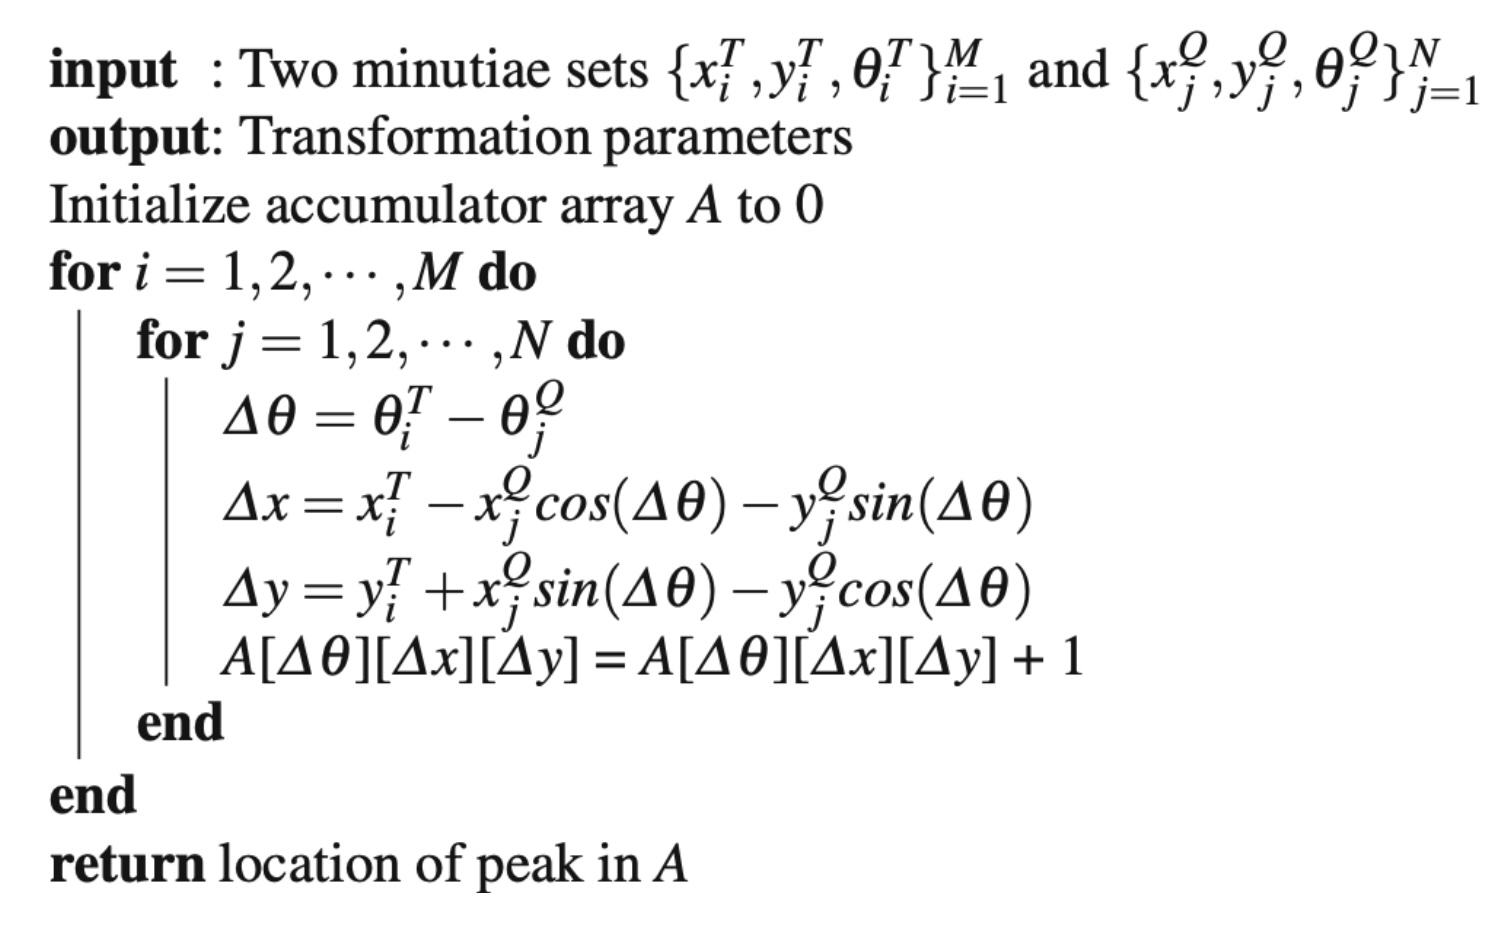

In [ ]:
# @title Hough Transform
def Hough_transform(enrollment_minutiae,test_minutiae):
  # Initialize accumulator array A to 0
  A = np.zeros((2*180+1,2*(image.shape[0]+image.shape[1])+2,2*(image.shape[0]+image.shape[1])+2))
  for i in range(0,len(enrollment_minutiae)):
    angle_i = enrollment_minutiae[i][3]
    x_i = enrollment_minutiae[i][0]
    y_i = enrollment_minutiae[i][1]
    for j in range(0,len(test_minutiae)):
      angle_j = test_minutiae[j][3]
      x_j = test_minutiae[j][0]
      y_j = test_minutiae[j][1]

      delta_angle = int(abs(angle_i - angle_j))
      delta_x = int(abs(x_i - x_j*math.cos(math.radians(delta_angle)) - y_j*math.sin(math.radians(delta_angle))))
      delta_y = int(abs(y_i + x_j*math.cos(math.radians(delta_angle)) - y_j*math.cos(math.radians(delta_angle))))
      A[delta_angle][delta_x][delta_y] += 1

  # Return location of peak in A
  max_indices = np.unravel_index(np.argmax(A), A.shape)
  return max_indices

# Decision
**Similarity-Based Decision:** The number of minutiae matches express the two fingerprint samples

**Simple score:**

Let M be the number of minutiae in image i

Let N be the number of minutiae in image j

*score = (#matches)/((M+N)/2)*

In [ ]:
def simple_score(enrollment_minutiae,test_minutiae,delta_angle,delta_x,delta_y):
  matches = 0
  threshold = 5

  for i in range(0,len(enrollment_minutiae)):
    enrollment_angle = enrollment_minutiae[i][3]
    enrollment_x = enrollment_minutiae[i][0]
    enrollment_y = enrollment_minutiae[i][1]
    for j in range(0,len(test_minutiae)):
      test_angle = test_minutiae[j][3]
      test_x = test_minutiae[j][0]
      test_y = test_minutiae[j][1]

      if ((enrollment_angle + delta_angle)%360 < (test_angle + threshold)) and ((enrollment_angle + delta_angle)%360 > (test_angle - threshold)):
        if ((enrollment_x + delta_x) < (test_x + threshold)) and ((enrollment_x + delta_x) > (test_x - threshold)):
          if ((enrollment_y + delta_y) < (test_y + threshold)) and ((enrollment_y + delta_y) > (test_y - threshold)):
            matches += 1

  score = matches / ((len(enrollment_minutiae) + len(test_minutiae)) / 2)


  return [matches, score]

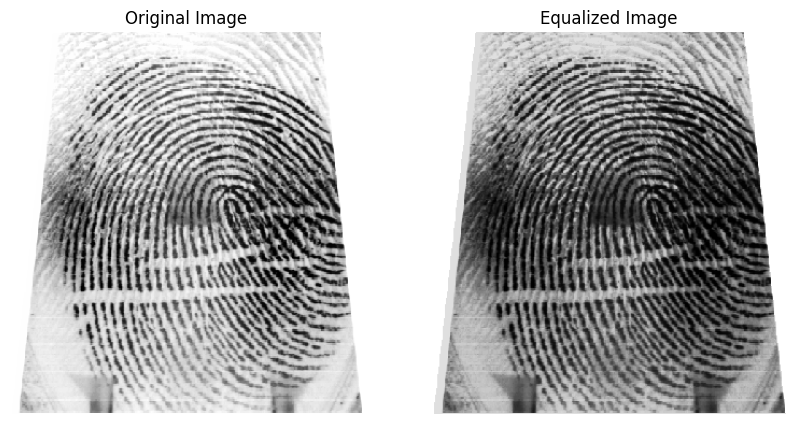

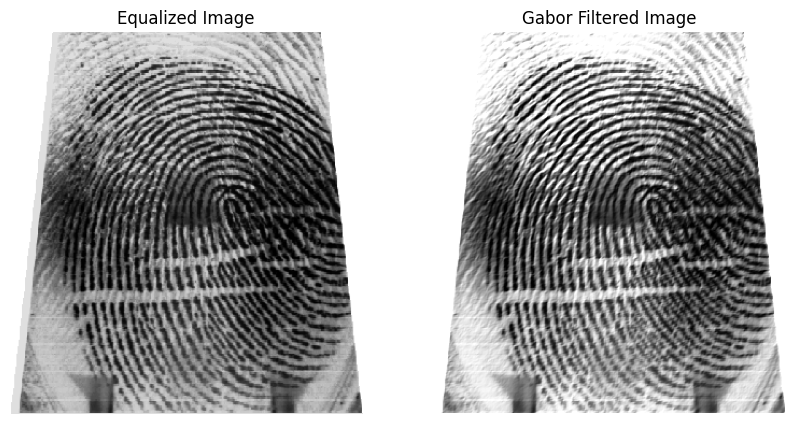

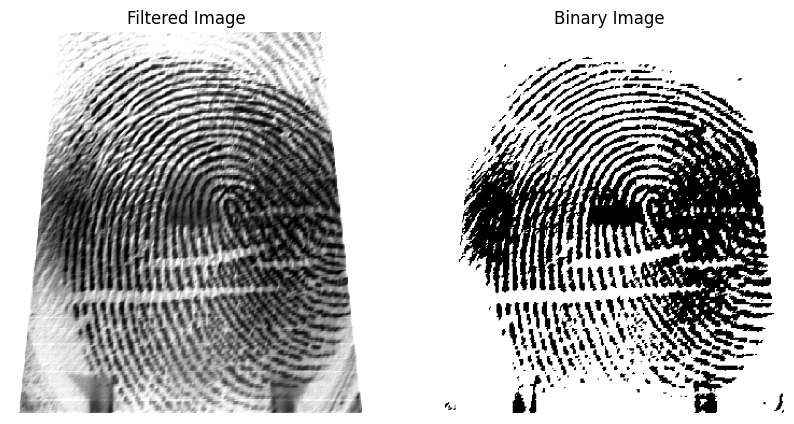

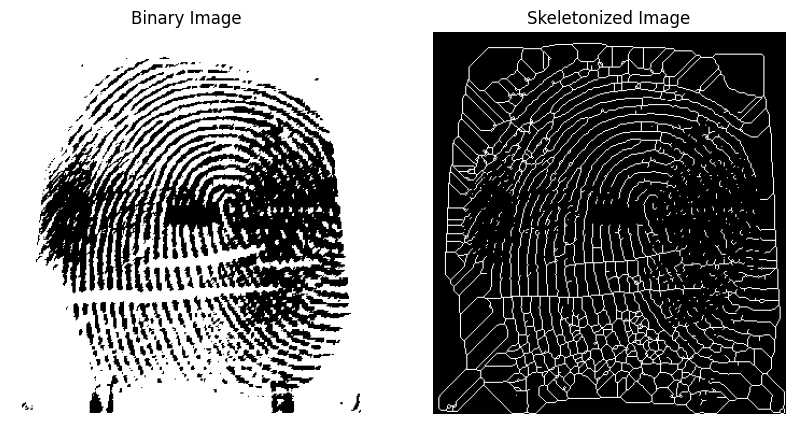

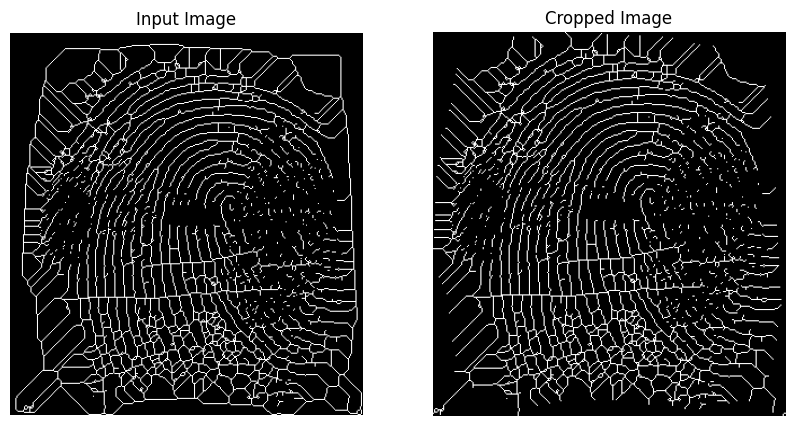

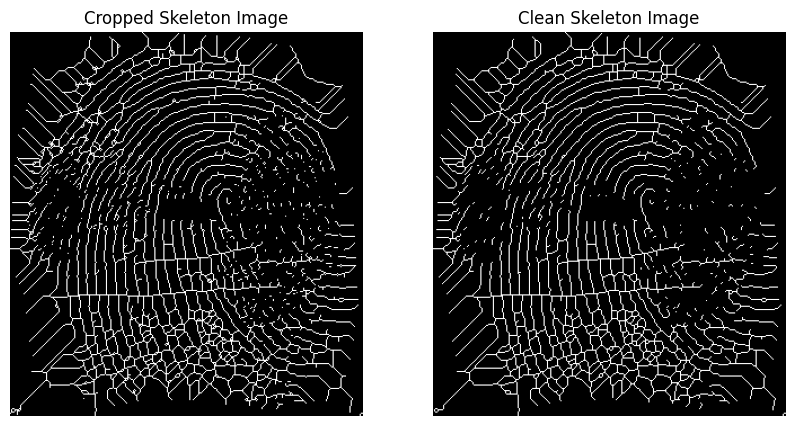

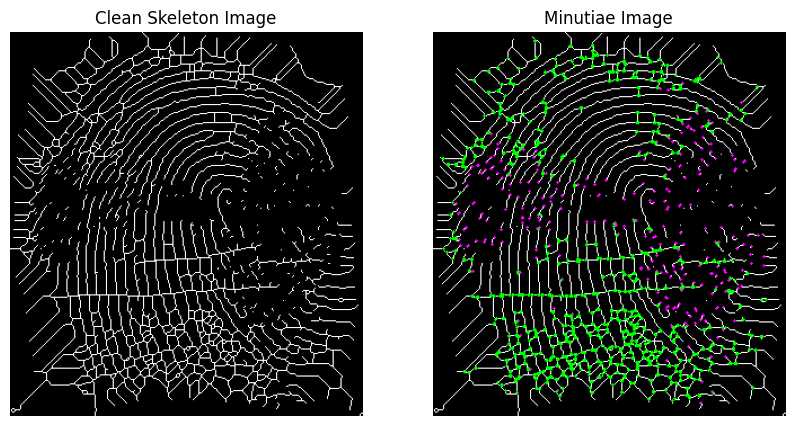

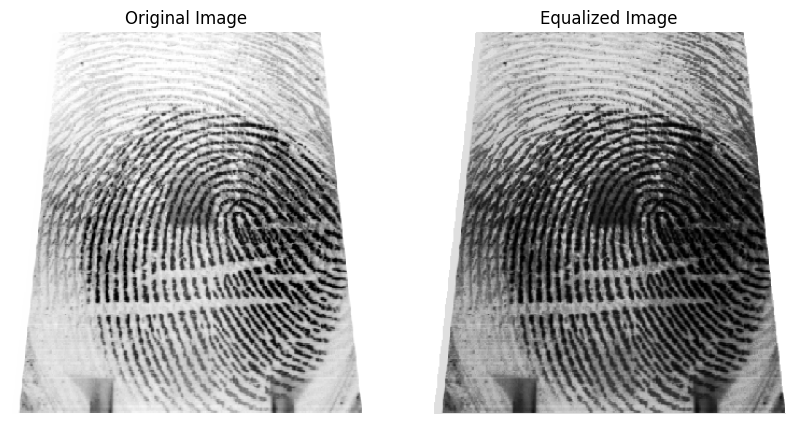

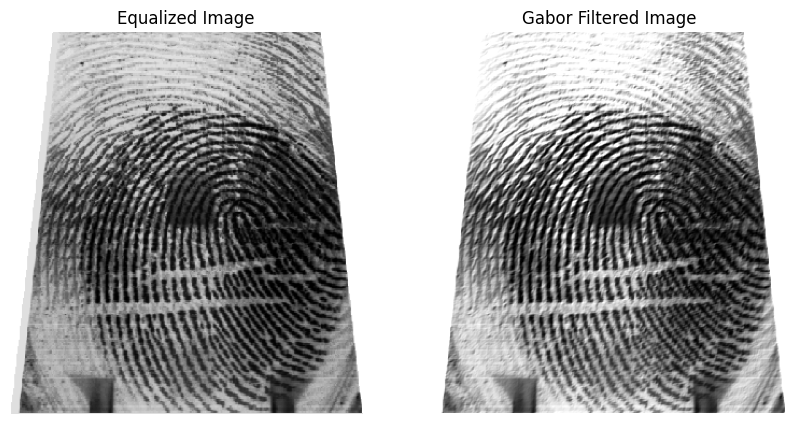

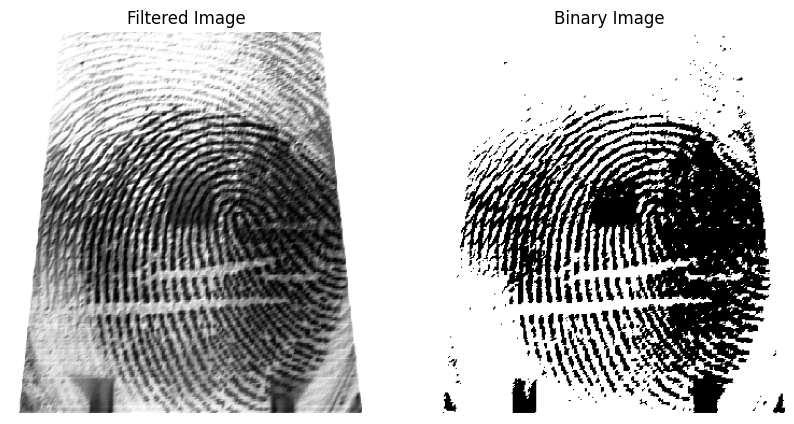

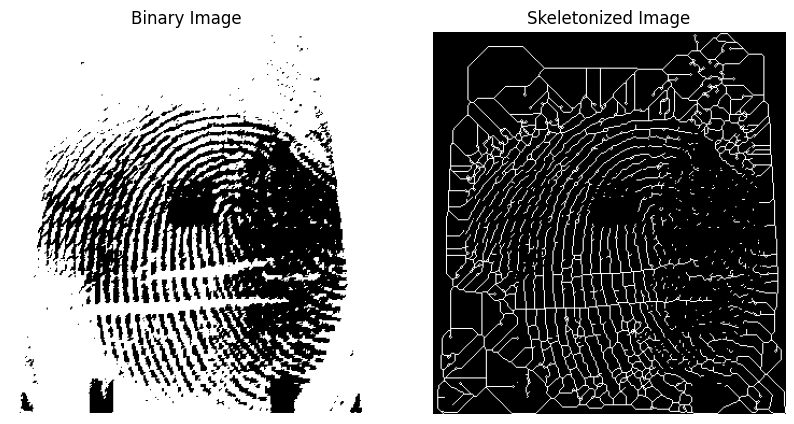

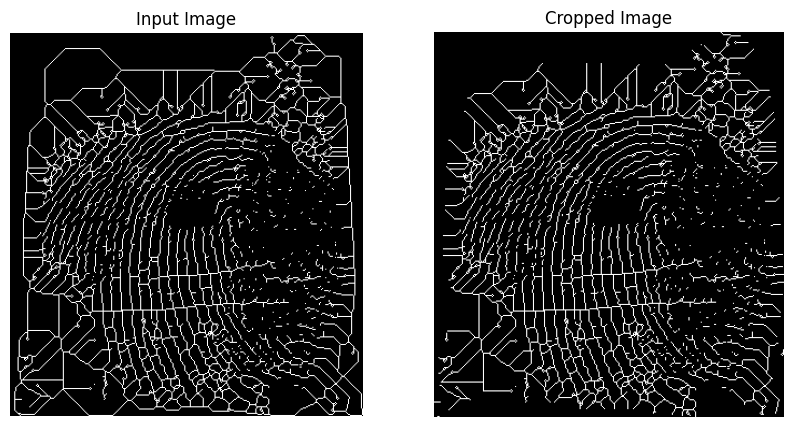

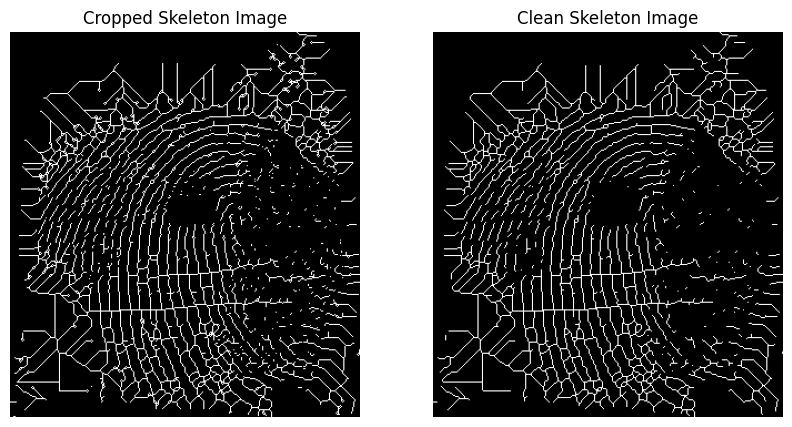

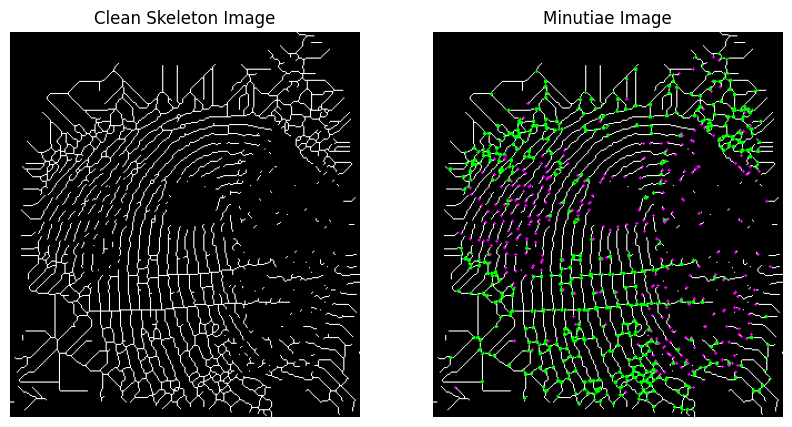

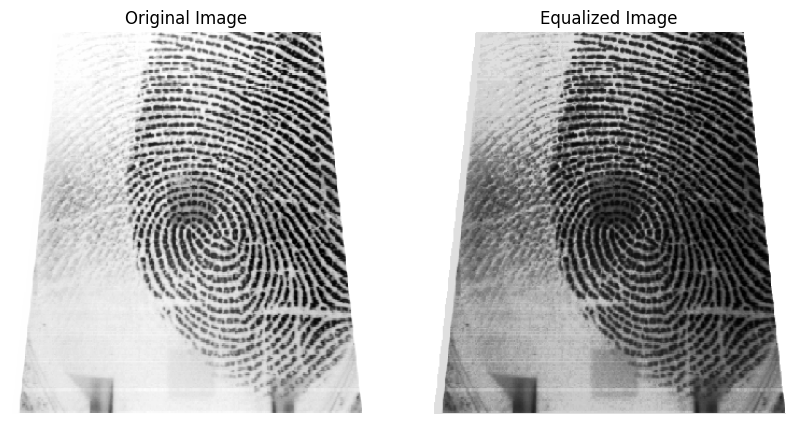

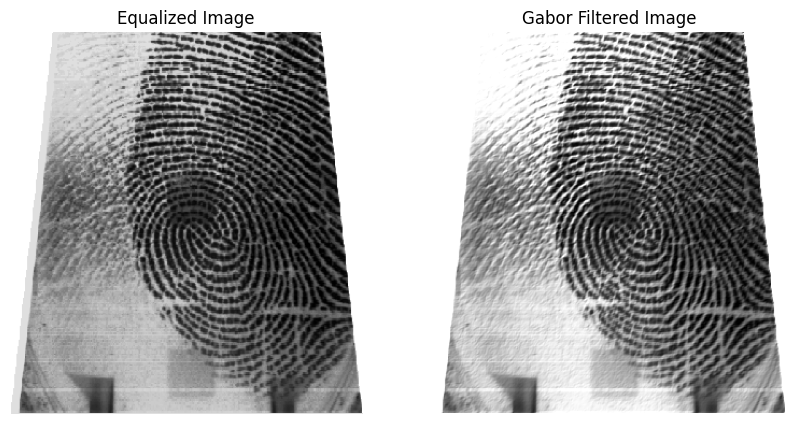

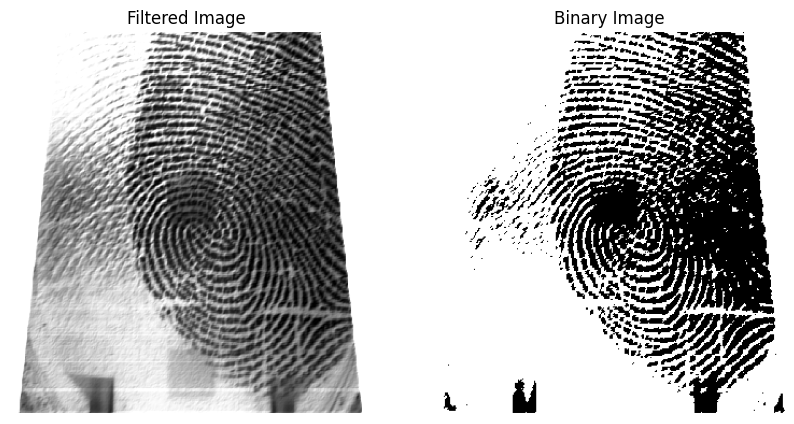

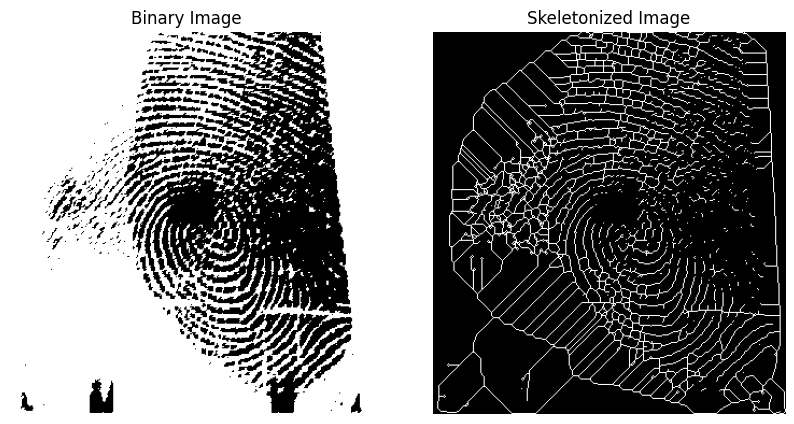

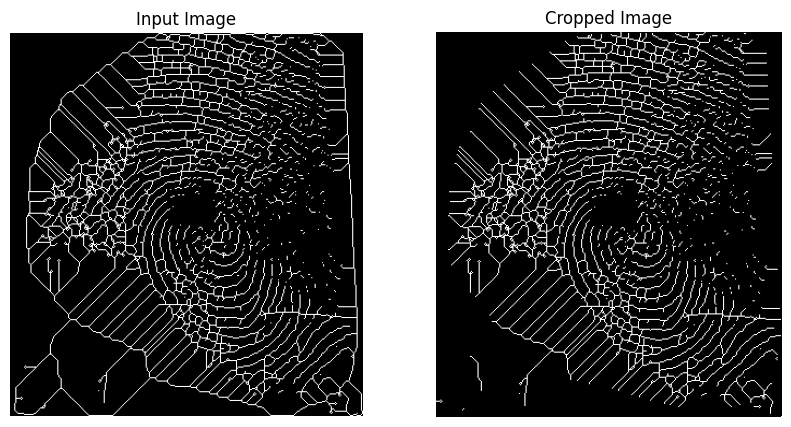

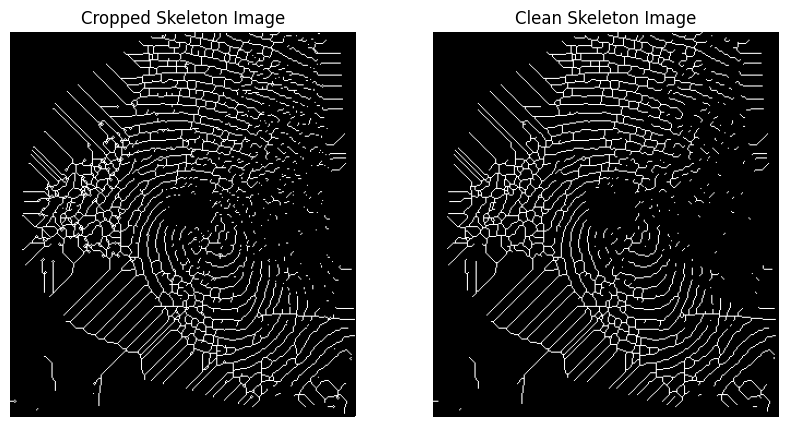

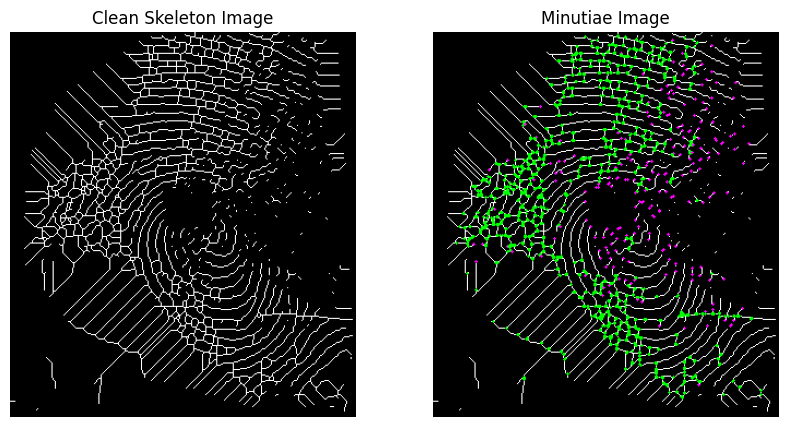

In [ ]:
# Enrollment (training) image
file_path = '/content/drive/My Drive/CSC_591-027/train/009_R0_0.bmp'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Get minutiae
enrollment_minutiae = return_minutiae(image,1)

# Test image
file_path = '/content/drive/My Drive/CSC_591-027/test/009_R0_4.bmp'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Get minutiae
test_minutiae = return_minutiae(image,1)

# Attack image
file_path = '/content/drive/My Drive/CSC_591-027/test/008_R0_4.bmp'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Get minutiae
attack_minutiae = return_minutiae(image,1)

In [ ]:
print("enrollment_minutiae:\t",enrollment_minutiae)
print("      test_minutiae:\t",test_minutiae)
print("    attack_minutiae:\t",attack_minutiae)

enrollment_minutiae:	 [[90, 7, 'Bifurcation', 0.0], [90, 8, 'Bifurcation', -45.0], [141, 11, 'Bifurcation', 135.0], [121, 12, 'Bifurcation', 0.0], [122, 12, 'Bifurcation', -135.0], [141, 12, 'Bifurcation', -135.0], [141, 16, 'Bifurcation', 18.43494882292201], [141, 17, 'Bifurcation', -45.0], [142, 19, 'Bifurcation', 90.0], [142, 20, 'Bifurcation', 0.0], [144, 20, 'Bifurcation', -45.0], [145, 20, 'Bifurcation', -90.0], [146, 20, 'Bifurcation', -135.0], [154, 20, 'Bifurcation', -90.0], [183, 20, 'Bifurcation', 135.0], [142, 21, 'Bifurcation', -90.0], [183, 21, 'Bifurcation', -135.0], [91, 22, 'Bifurcation', 45.0], [130, 22, 'Bifurcation', -45.0], [131, 22, 'Bifurcation', -90.0], [132, 22, 'Bifurcation', 180.0], [141, 22, 'Bifurcation', 90.0], [190, 22, 'Bifurcation', 180.0], [252, 22, 'Bifurcation', 0.0], [66, 23, 'Bifurcation', -135.0], [91, 23, 'Bifurcation', -90.0], [108, 23, 'Bifurcation', 180.0], [133, 23, 'Bifurcation', 45.0], [135, 23, 'Bifurcation', -90.0], [136, 23, 'Bifurcation

In [ ]:
# @title Score for same person
[delta_angle,delta_x,delta_y] = Hough_transform(enrollment_minutiae,test_minutiae)
[matches, score] = simple_score(enrollment_minutiae,test_minutiae,delta_angle,delta_x,delta_y)
print(delta_angle,delta_x,delta_y)
print(matches)
print(score)

90 2 233
62
0.03835446953294154


In [ ]:
# @title Score for imposter
[delta_angle,delta_x,delta_y] = Hough_transform(enrollment_minutiae,attack_minutiae)
[matches, score] = simple_score(enrollment_minutiae,attack_minutiae,delta_angle,delta_x,delta_y)
print(delta_angle,delta_x,delta_y)
print(matches)
print(score)

90 55 233
33
0.019849624060150377


# Enrollment
Enroll training images in system dictionary.
Perhaps Use Numpy

In [ ]:
small_train = []
for i in range(0,5):
#for i in range(0,1): # range of people
  for j in range(0,3):
  #for j in range(0,1): # range of fingerprints
    if i < 10:
      file_name = '00'+str(i)+'_R0_'+str(j)+'.bmp'
    elif i < 100:
      file_name = '0'+str(i)+'_R0_'+str(j)+'.bmp'
    else:
      file_name = str(i)+'_R0_'+str(j)+'.bmp'
    small_train.append(file_name)
print(len(small_train))
print((small_train))

15
['000_R0_0.bmp', '000_R0_1.bmp', '000_R0_2.bmp', '001_R0_0.bmp', '001_R0_1.bmp', '001_R0_2.bmp', '002_R0_0.bmp', '002_R0_1.bmp', '002_R0_2.bmp', '003_R0_0.bmp', '003_R0_1.bmp', '003_R0_2.bmp', '004_R0_0.bmp', '004_R0_1.bmp', '004_R0_2.bmp']


In [ ]:
print(i,j)

4 2


In [ ]:
# Intialize dictionary
enrollment_minutiae = {}
for person in range(0,i+1):
  if person < 10:
    key = '00'+str(person)
  elif i < 100:
    key = '0'+str(person)
  else:
    key = str(person)
  enrollment_minutiae[key] = []

print(enrollment_minutiae)

# Enroll images
for file_name in small_train:
  file_path = 'train/'+file_name
  image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  # Record the start time
  start_time = time.time()
  enrollment_minutiae[file_name[0:3]].append((return_minutiae(image,0)))
  # Record the end time
  end_time = time.time()
  # Calculate the elapsed time
  elapsed_time = end_time - start_time
  print("enrolled: ",file_name," in ",elapsed_time," seconds")

{'000': [], '001': [], '002': [], '003': [], '004': []}
enrolled:  000_R0_0.bmp  in  29.910105228424072  seconds
enrolled:  000_R0_1.bmp  in  27.581817150115967  seconds
enrolled:  000_R0_2.bmp  in  22.085689067840576  seconds
enrolled:  001_R0_0.bmp  in  2.99885630607605  seconds
enrolled:  001_R0_1.bmp  in  9.976838111877441  seconds
enrolled:  001_R0_2.bmp  in  6.38561487197876  seconds
enrolled:  002_R0_0.bmp  in  28.577633142471313  seconds
enrolled:  002_R0_1.bmp  in  3.9746620655059814  seconds
enrolled:  002_R0_2.bmp  in  5.556396722793579  seconds
enrolled:  003_R0_0.bmp  in  41.73094916343689  seconds
enrolled:  003_R0_1.bmp  in  32.05044198036194  seconds
enrolled:  003_R0_2.bmp  in  58.6994149684906  seconds
enrolled:  004_R0_0.bmp  in  11.12031602859497  seconds
enrolled:  004_R0_1.bmp  in  3.099123954772949  seconds
enrolled:  004_R0_2.bmp  in  3.206707000732422  seconds


In [ ]:
print(enrollment_minutiae)
print()

{'000': [[[72, 6, 'Bifurcation', -45.0], [73, 6, 'Bifurcation', 180.0], [120, 6, 'Bifurcation', -90.0], [152, 6, 'Bifurcation', -90.0], [161, 6, 'Bifurcation', 90.0], [96, 7, 'Bifurcation', -90.0], [105, 7, 'Bifurcation', -45.0], [106, 7, 'Bifurcation', -90.0], [161, 7, 'Bifurcation', 180.0], [161, 8, 'Bifurcation', -90.0], [77, 9, 'Bifurcation', 0.0], [112, 9, 'Bifurcation', -135.0], [77, 10, 'Bifurcation', -90.0], [171, 10, 'Bifurcation', -90.0], [47, 11, 'Bifurcation', 45.0], [163, 11, 'Bifurcation', -90.0], [47, 12, 'Bifurcation', 0.0], [106, 12, 'Ending', 135.0], [47, 13, 'Bifurcation', -90.0], [34, 14, 'Bifurcation', 180.0], [126, 15, 'Bifurcation', 45.0], [94, 16, 'Bifurcation', -90.0], [95, 16, 'Bifurcation', -135.0], [100, 16, 'Bifurcation', 45.0], [104, 16, 'Bifurcation', -45.0], [105, 16, 'Bifurcation', -90.0], [106, 16, 'Bifurcation', -135.0], [109, 16, 'Bifurcation', 45.0], [112, 16, 'Bifurcation', -90.0], [113, 16, 'Bifurcation', -135.0], [126, 16, 'Bifurcation', -45.0], 

In [ ]:
small_test = []
for i in range(0,5):
#for i in range(0,1): # range of people
  # all fingerprint images end in '_4.bmp'
  if i < 10:
    file_name = '00'+str(i)+'_R0_4.bmp'
  elif i < 100:
    file_name = '0'+str(i)+'_R0_4.bmp'
  else:
    file_name = str(i)+'_R0_4.bmp'
  small_test.append(file_name)
print(len(small_test))
print((small_test))

5
['000_R0_4.bmp', '001_R0_4.bmp', '002_R0_4.bmp', '003_R0_4.bmp', '004_R0_4.bmp']


In [ ]:
for test_image in small_test:
  # Initialize scores to zero
  scores = enrollment_minutiae.copy()
  for key, values in scores.items():
    scores[key] = 0

  file_path = 'test/'+test_image
  image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  test_minutiae = return_minutiae(image,0)

  # Compare test minutiae against all enrolled fingerprints
  for person, fingerprints in enrollment_minutiae.items():
    for fingerprint in fingerprints:
      [delta_angle,delta_x,delta_y] = Hough_transform(fingerprint,test_minutiae)
      [matches, score] = simple_score(fingerprint,test_minutiae,delta_angle,delta_x,delta_y)
      if score > scores[person]:
        scores[person] = score
  # Find enrolled person corresponding to largest score
  max_score = max(scores.values())
  max_person = [person for person, score in scores.items() if score == max_score]
  print("test_image: ",test_image," max_score: ",max_score," max_person: ",max_person)


test_image:  000_R0_4.bmp  max_score:  0.07829869502174963  max_person:  ['000']
test_image:  001_R0_4.bmp  max_score:  0.06458557588805167  max_person:  ['001']
test_image:  002_R0_4.bmp  max_score:  0.06705471478463329  max_person:  ['002']
test_image:  003_R0_4.bmp  max_score:  0.14965986394557823  max_person:  ['002']
test_image:  004_R0_4.bmp  max_score:  0.0700218818380744  max_person:  ['002']


In [ ]:
print(scores)

{'000': 0.0013380909901873326}


# Evaluation
Evaluate the performance of the built fingerprint authentication system and visualize the results.

Accuracy: 60.00


ValueError: Classification metrics can't handle a mix of binary and continuous targets

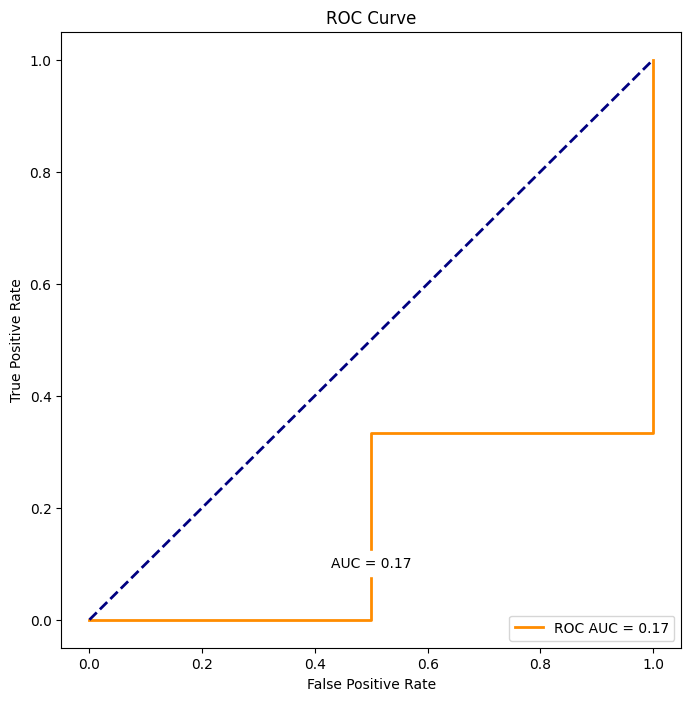

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


def process_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return return_minutiae(image, 0)

def calculate_scores(enrollment_minutiae, test_minutiae):
    scores = {key: 0 for key in enrollment_minutiae}

    for person, fingerprints in enrollment_minutiae.items():
        for fingerprint in fingerprints:
            [delta_angle, delta_x, delta_y] = Hough_transform(fingerprint, test_minutiae)
            [matches, score] = simple_score(fingerprint, test_minutiae, delta_angle, delta_x, delta_y)
            if isinstance(scores[person], list):
                # If scores[person] is a list, take the maximum of its elements
                scores[person] = max(scores[person] + [score])
            else:
                scores[person] = max(scores[person], score)

    return scores

def evaluate_matching(enrollment_minutiae, folder, test_images, return_details=False):
    scores_list, labels_list = [], []
    correct_matches = 0  # Initialize variable for accuracy calculation

    true_positives, false_positives, false_negatives, true_negatives = 0, 0, 0, 0  # Initialize variables for confusion matrix

    for test_image in test_images:
        file_path = f'{folder}/{test_image}'
        test_minutiae = process_image(file_path)

        scores = calculate_scores(enrollment_minutiae, test_minutiae)

        scores_array = np.array(list(scores.values()))
        max_person = np.argmax(scores_array)
        max_score = scores_array[max_person]
        actual_person = int(test_image[0:3])

        scores_list.append(max_score)
        labels_list.append(1 if max_person == actual_person else 0)

        # Check if the identified person is correct
        if max_person == actual_person:
            correct_matches += 1
            if max_person == 1:  # Positive class
                true_positives += 1
            else:  # Negative class
                true_negatives += 1
        else:
            if max_person == 1:  # Model predicted positive, but actual is negative
                false_positives += 1
            else:  # Model predicted negative, but actual is positive
                false_negatives += 1

        if return_details:
            print(f"test_image: {test_image}, max_score: {max_score}, max_person: {max_person}, actual_person: {actual_person}, {'Matched' if max_person == actual_person else 'Not Matched'}")

    # Calculate and print Accuracy
    total_matches = len(test_images)
    accuracy = (correct_matches / total_matches) * 100
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate and print AUC
    roc_auc = roc_auc_score(labels_list, scores_list)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(labels_list, scores_list)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Display AUC value on the plot
    plt.text(0.5, 0.1, f'AUC = {roc_auc:.2f}', ha='center', va='center', backgroundcolor='white', fontsize=10)

    # Calculate and print Precision, Recall, F1 Score, and Specificity without a threshold
    precision = precision_score(labels_list, scores_list)
    recall = recall_score(labels_list, scores_list)
    f1 = f1_score(labels_list, scores_list)
    accuracy = accuracy_score(labels_list, scores_list)

    # Calculate specificity
    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print("Confusion Matrix:")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"True Negatives: {true_negatives}")

    plt.show()

    if return_details:
        return fpr, tpr
    else:
        return None

# Usage
enroll_folder = "train"
test_folder = "test"
evaluate_matching(enrollment_minutiae, test_folder, small_test, return_details=False)



User 0:
	True Positives (TP): 1
	True Negatives (TN): 4
	False Positives (FP): 0
	False Negatives (FN): 0
User 1:
	True Positives (TP): 1
	True Negatives (TN): 4
	False Positives (FP): 0
	False Negatives (FN): 0
User 2:
	True Positives (TP): 1
	True Negatives (TN): 2
	False Positives (FP): 2
	False Negatives (FN): 0
User 3:
	True Positives (TP): 0
	True Negatives (TN): 4
	False Positives (FP): 0
	False Negatives (FN): 1
User 4:
	True Positives (TP): 0
	True Negatives (TN): 4
	False Positives (FP): 0
	False Negatives (FN): 1


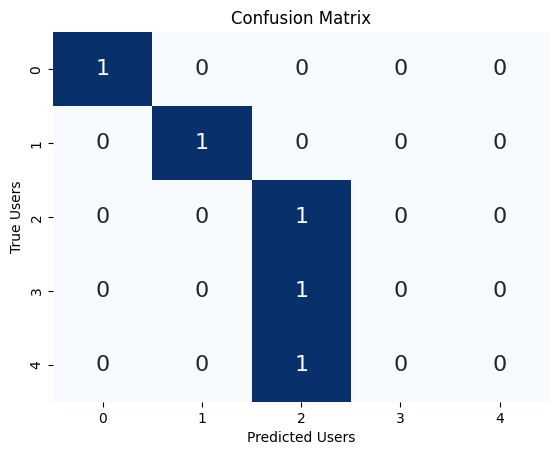

Accuracy:  0.6
F1 Score:  0.5249999999999999
Precision:  0.4666666666666667
Recall:  0.6
Specificity:  0.9


In [67]:
import seaborn as sns 

y_pred = ['000','001','002','002','002']
y_true = ['000','001','002','003','004']

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


# Extract values from the confusion matrix
for i in range(5):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    
    print(f"User {i}:")
    print(f"\tTrue Positives (TP): {TP}")
    print(f"\tTrue Negatives (TN): {TN}")
    print(f"\tFalse Positives (FP): {FP}")
    print(f"\tFalse Negatives (FN): {FN}")

accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

precision_per_class = np.zeros(5)
for i in range(5):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    if true_positives + false_positives > 0:
        precision_per_class[i] = true_positives / (true_positives + false_positives)
    else:
        precision_per_class[i] = 0  # Handle division by zero when denominator is zero
# Calculate overall precision
precision = np.mean(precision_per_class)

recall_per_class = np.zeros(5)
for i in range(5):
    true_positives = conf_matrix[i, i]
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives
    if true_positives + false_negatives > 0:
        recall_per_class[i] = true_positives / (true_positives + false_negatives)
    else:
        recall_per_class[i] = 0  # Handle division by zero when denominator is zero
# Calculate overall recall
recall = np.mean(recall_per_class)

f1 = 2 * (precision * recall) / (precision + recall) 

specificity_per_class = np.zeros(5)
for i in range(5):
    true_positives = conf_matrix[i, i]
    true_negatives = np.sum(np.delete(conf_matrix, i, axis=0)[:, np.arange(5) != i])
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    if false_positives < 0:
        false_positives = 0
    if true_negatives + false_positives > 0:
        specificity_per_class[i] = true_negatives / (true_negatives + false_positives)
    else:
        specificity_per_class[i] = 0  # Handle division by zero when denominator is zero
# Calculate overall specificity
specificity = np.mean(specificity_per_class)

# Display confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Users')
plt.ylabel('True Users')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)